<a href="https://colab.research.google.com/github/AlexanderCoudijzer/k-means_clustering/blob/main/k_means_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# k-means clustering from scratch

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans #only used for testing purposes

## 1. Datasets
2 datasets are prepared:  
- data1: a simple 8 points for initial testing
- seeds: the seeds dataset from the UCI machine learning data repository:
https://archive.ics.uci.edu/ml/datasets/seeds. There are 7 attributes, the 8th column of the file is a class label, which is not loaded.

In [4]:
data1=np.array([[1, 1], [1, 3], [3, 1], [3, 3], [5, 5], [5, 7], [7, 5], [7, 7]])

seeds=np.array(pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt',\
                     engine='python', delimiter='\t+', header=None, usecols=[0, 1, 2, 3, 4, 5, 6]))

## 2. Implementation

In [7]:
class KMeansClustering:
    def __init__(self, data):
        self.description = 'Clustering data in k number of clusters. Takes a Numpy array as input data.'
        self.data = data
        
    def calc_sq_dist(self, centroid, point):
        """ Calculates the square Euclidean distance between 2 data points """
        sq_dist = sum([(centroid[j]-point[j])**2 for j in range(len(point))])
        return sq_dist
    
    def init_centroids(self, k):
        """ Selects k random points as initial centroids """
        random_index = np.random.choice(self.data.shape[0], size=k, replace=False)
        centroids_array = self.data[random_index, :]
        return centroids_array

    def init_centroids_plus_plus(self, k):
        """ Selects initial centroids using k-means++ """
        centroids_array = self.init_centroids(k)
        while len(centroids_array) < k:
            point_sq_dist = []    
            for point in self.data:
                sq_dist_list = []
                for centroid in centroids_array:
                    sq_dist_list.append(self.calc_sq_dist(centroid,point))   
                point_sq_dist.append(min(sq_dist))
            np.concatenate((centroids_array,np.array([random.choices(self.data,weights=point_sq_dist)])))
        return centroids_array

    def assign_clusters(self, centroids_array):
        """ Assigns a label to each data point, selecting the cluster of the closest centroid """
        clusters_list = []
        for point in self.data:
            sq_dist_list = []
            for centroid in centroids_array:
                sq_dist_list.append(self.calc_sq_dist(centroid,point))
            clusters_list.append([np.argmin(sq_dist_list)])
        return np.array(clusters_list)
    
    def recalc_centroids(self, k, clusters_list):
        """ Re-calculates the centroids based on the new clusters """
        dimensions = self.data.shape
        centroids_array = np.empty((k,dimensions[1]))
        for cluster in np.unique(clusters_list):
            centroids_array[cluster] = np.mean(self.data[(clusters_list == cluster).flatten()],axis=0)
        return centroids_array

    def calc_sq_dist_totals(self, centroids_array, clusters_list):
        """ Calculates the inertia, which is the sum of squared distances from data points to
        their centroids 
        """
        sq_dist_totals = 0
        for cluster in np.unique(clusters_list):
            for point in self.data[(clusters_list == cluster).flatten()]:
                centroid = centroids_array[cluster]
                sq_dist_totals += self.calc_sq_dist(centroid, point)
        return sq_dist_totals

    def clustering(self, k, iterations=200, tol=0.0001, init='plus_plus', rerun=20):
        """ Performs the clustering using the functions defined above. It will iterate until 
        the provided limit or until the Frobenius norm of the centroids difference falls below
        the tolerance (tol).
        The algorithm will also rerun several times and return the solution with the lowest inertia.
        """
        self.k = k
        dimensions = len(self.data[0])
        inertia_min = 9999999999.0
        solution = []
        for r in range(rerun):   
            if init == 'plus_plus':
                centroids_array=self.init_centroids_plus_plus(k)
            elif init == 'random':
                centroids_array = self.init_centroids(k)
            frob_diff=9999999999.0
            iteration=1.0
            while frob_diff > tol and iteration < float(iterations):
                clusters_list = self.assign_clusters(centroids_array)
                centroids_array_old = centroids_array.copy()
                centroids_array = self.recalc_centroids(k, clusters_list)
                frob_diff=sqrt(np.sum((centroids_array_old - centroids_array)**2))
                iteration += 1
            inertia_run=self.calc_sq_dist_totals(centroids_array, clusters_list)
            if inertia_run < inertia_min:
                inertia_min = inertia_run
                solution = [centroids_array,clusters_list]
        self.cent =  solution[0]
        self.clusters = solution[1]
        return self.cent, self.clusters

    def calc_inertia(self, k_range=[1, 10]):
        """ Calculates the inertia for a range of k values, to help determin the optimal number of clusters """
        clusters_num = []
        inertia_list = []
        for k in range(k_range[0], k_range[1]):
            if k >= len(self.data):
                break
            centroids, clusters = self.clustering(k)
            inertia = self.calc_sq_dist_totals(centroids, clusters)
            print("inertia for", k, "clusters:", inertia)
            clusters_num.append(k)
            inertia_list.append(inertia)
        plt.plot(clusters_num, inertia_list)
        plt.xlabel('number of clusters')
        plt.ylabel('inertia')
        plt.xticks(clusters_num)
        plt.show()      

## 3. Testing

### 3.1. Test harness

In [8]:
#unit tests
def test_k_means_init(data,k):
    dummy = KMeansClustering(data)
    centroids = dummy.init_centroids(k)
    centroids2 = dummy.init_centroids_plus_plus(k)
    assert np.isin(centroids,data).all
    assert centroids.shape == (k, data.shape[1])
    assert np.isin(centroids2,data).all
    assert centroids2.shape == (k, data.shape[1])

def test_k_means_sq_dist():
    dummy = KMeansClustering(data1)
    test1 = dummy.calc_sq_dist([0, 0], [0, 0])
    test2 = dummy.calc_sq_dist([0, 0], [3, 4])
    test3 = dummy.calc_sq_dist([1, 1], [-1.5, -2.5])
    assert test1 == 0
    assert test2 == 25
    assert test3 == 18.5

def test_k_means_assign(data,k):
    dummy = KMeansClustering(data)
    centroids=dummy.init_centroids(k)
    test1 = dummy.assign_clusters(centroids)
    assert len(test1) == len(data)
    assert len(np.unique(test1)) == k

def test_k_means_recalc(data,k):
    dummy = KMeansClustering(data)
    centroids = dummy.init_centroids(k)
    label = dummy.assign_clusters(centroids)
    centroids = dummy.recalc_centroids(k, label)
    assert centroids.shape == (k, data.shape[1])
    
# integration tests    
def test_k_means_result(data, k, result):
    centroids,clusters = KMeansClustering(data).clustering(k)
    assert (centroids == result).all

def test_k_means_compare(data, k):
    centroids, clusters = KMeansClustering(data).clustering(k)
    kmeans = KMeans(n_clusters=k).fit(data)
    assert (centroids == kmeans.cluster_centers_).all


### 3.2 Running the tests

In [9]:
#unit tests
test_k_means_init(data1, 2)
test_k_means_init(data1, 4)
test_k_means_sq_dist()
test_k_means_assign(data1, 2)
test_k_means_assign(data1, 5)
test_k_means_recalc(data1, 2)

#integration tests
test_k_means_result(data1, 1, [4, 4])
test_k_means_result(data1, 2, [[2, 2], [6, 6]])
test_k_means_compare(data1, 2)
test_k_means_compare(data1, 7)
test_k_means_compare(seeds, 3)

## 4. Application of k-means clustering

As a first validation the k-means clustering is applied to dataset 1:

inertia for 1 clusters: 80.0
inertia for 2 clusters: 16.0
inertia for 3 clusters: 12.0
inertia for 4 clusters: 8.0
inertia for 5 clusters: 6.0
inertia for 6 clusters: 4.0
inertia for 7 clusters: 2.0


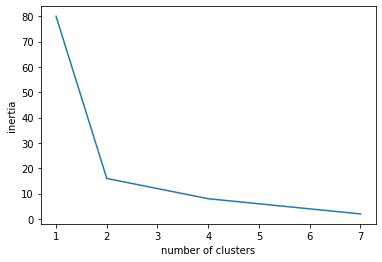

For  2 clusters, the centroids are:
 [[6. 6.]
 [2. 2.]]


In [12]:
kmeans_data1 = KMeansClustering(data1)
kmeans_data1.calc_inertia() # first working out the optimal amount of clusters
kmeans_data1.clustering(2)
print('For %2i clusters, the centroids are:\n' %kmeans_data1.k, kmeans_data1.cent)

Finally, the clustering is applied to the seeds dataset:

inertia for 1 clusters: 2719.8524101779535
inertia for 2 clusters: 1011.6122645866978
inertia for 3 clusters: 587.3186115940426
inertia for 4 clusters: 471.00339552519205
inertia for 5 clusters: 385.5072923490439
inertia for 6 clusters: 323.4198805909312


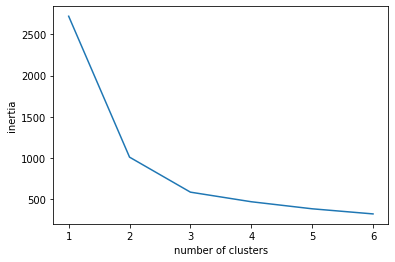

For  3 clusters, the centroids are:
 [[14.64847222 14.46041667  0.87916667  5.56377778  3.27790278  2.64893333
   5.19231944]
 [18.72180328 16.29737705  0.88508689  6.20893443  3.72267213  3.60359016
   6.06609836]
 [11.96441558 13.27480519  0.8522      5.22928571  2.87292208  4.75974026
   5.08851948]]


In [13]:
kmeans_seeds = KMeansClustering(seeds)
kmeans_seeds.calc_inertia([1, 7])
cent,label = kmeans_seeds.clustering(3)
print('For %2i clusters, the centroids are:\n' %kmeans_seeds.k, kmeans_seeds.cent)

## 5. Visualisation of results
Seaborn's scatterplot was used as it made dealing with coloured points easier. Pairplot was used as well, for its ability to display more than 2 features in a single display. 

In [14]:
class PlotKMeans:
    def __init__(self, obj):
        self.description = 'Plots the results of k-means clustering, takes a KMeansClustering object as input'
        self.obj = obj
        
    def plot_2d_input(self, attr=[0,1]):
        """Plots the data, for data with more than 2 attributes, 2 can be selected by providing a list of their indices"""
        to_plot_df = pd.DataFrame(self.obj.data)
        sns.scatterplot(x=to_plot_df[attr[0]], y=to_plot_df[attr[1]], palette='tab10')
        plt.title('Input')
        plt.show()
    
    def plot_2d_output(self, attr=[0,1]):
        """Plots the clustered data, for data with more than 2 attributes, 2 can be selected by providing a list 
        of their indices"""
        to_plot_df = pd.DataFrame(self.obj.data).assign(label=self.obj.clusters)
        sns.scatterplot(x=to_plot_df[attr[0]], y=to_plot_df[attr[1]], hue=to_plot_df['label'], palette='tab10')
        plt.title('Clustering result')
        plt.show()

    def plot_pairs_input(self, attr='all'):
        """Plots the data, all attributes by default but some can be selected by providing a list of their indices"""    
        if attr == 'all':
            to_plot_df = pd.DataFrame(self.obj.data)
        elif type(attr) == list:
            to_plot_df = pd.DataFrame(self.obj.data).iloc[:,attr]
        else:
            raise ValueError('If selecting a list of attributes to plot, provide the attribute indices as list')
        sns.pairplot(to_plot_df, palette='tab10', diag_kind='kde')
        plt.suptitle('Input', y=1.02)
        plt.show()

    def plot_pairs_output(self, attr='all'):
        """Plots the clustered data, all attributes by default but some can be selected by providing a list of their indices"""
        if attr == 'all':
            to_plot_df = pd.DataFrame(self.obj.data).assign(label=self.obj.clusters)
        elif type(attr) == list:
            to_plot_df = pd.DataFrame(self.obj.data).iloc[:, attr].assign(label=self.obj.clusters)
        else:
            raise ValueError('If selecting a list of attributes to plot, provide the attribute indices as list')
        sns.pairplot(to_plot_df, palette='tab10', hue='label')
        plt.suptitle('Clustering result', y=1.02)
        plt.show()

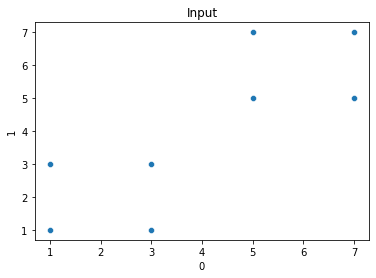

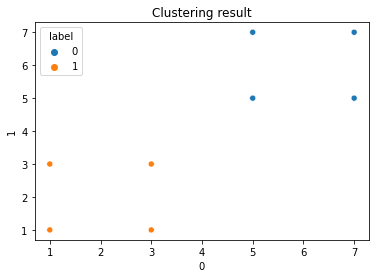

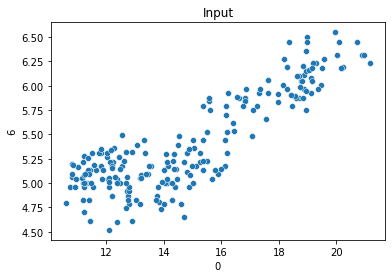

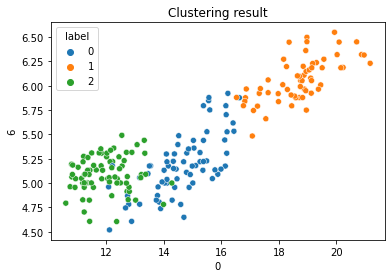

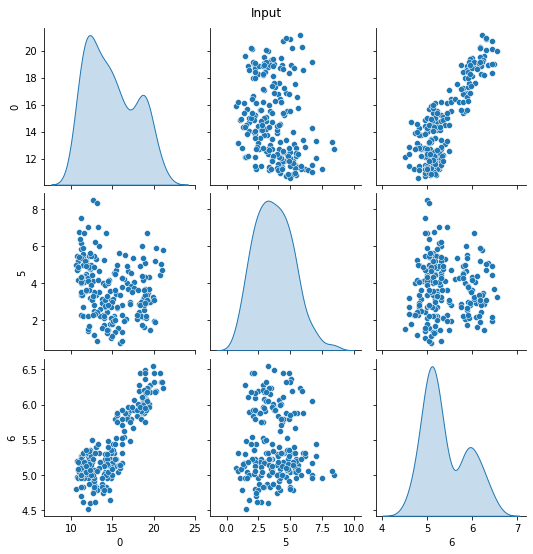

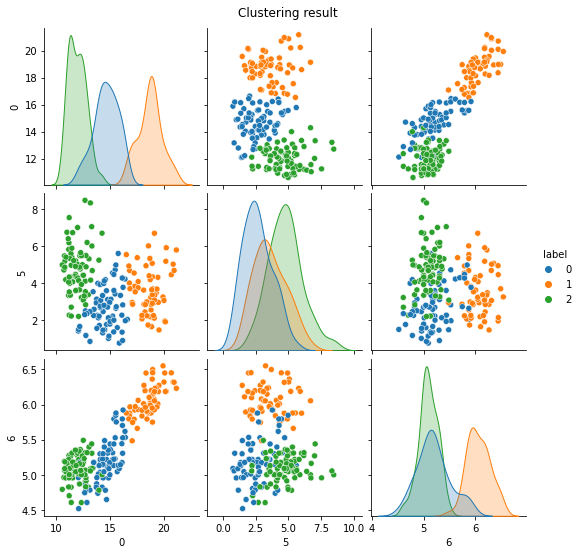

In [15]:
PlotKMeans(kmeans_data1).plot_2d_input()
PlotKMeans(kmeans_data1).plot_2d_output()
PlotKMeans(kmeans_seeds).plot_2d_input([0,6])
PlotKMeans(kmeans_seeds).plot_2d_output([0,6])
PlotKMeans(kmeans_seeds).plot_pairs_input([0,5,6])
PlotKMeans(kmeans_seeds).plot_pairs_output([0,5,6])

### References:
Charytanowicz, Magorzata, Niewczas, Jerzy, Kulczycki, Piotr, Kowalski, Piotr & Lukasik, Szymon. (2012). seeds. UCI Machine Learning Repository  
Aavailable at: https://archive.ics.uci.edu/ml/datasets/seeds

Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.  
KMeans clustering, available at: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

Wikipedia, k-means clustering  
Available at: https://en.wikipedia.org/wiki/K-means_clustering

Wikipedia, k-means++  
Available at: https://en.wikipedia.org/wiki/K-means%2B%2B
